# Installations and Imports

In [1]:
!git clone https://github.com/tensorflow/tpu/

Cloning into 'tpu'...
remote: Enumerating objects: 10524, done.
remote: Counting objects: 100% (726/726), done.
remote: Compressing objects: 100% (461/461), done.
remote: Total 10524 (delta 357), reused 500 (delta 251), pack-reused 9798
Receiving objects: 100% (10524/10524), 45.53 MiB | 28.85 MiB/s, done.
Resolving deltas: 100% (7395/7395), done.


In [2]:
from IPython import display
from PIL import Image
import numpy as np
%tensorflow_version 1.x
import tensorflow as tf
import sys
sys.path.insert(0, 'tpu/models/official')
sys.path.insert(0, 'tpu/models/official/mask_rcnn')
import coco_metric
from mask_rcnn.object_detection import visualization_utils
import cv2
from google.colab.patches import cv2_imshow
import math
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import math
import pandas as pd

TensorFlow 1.x selected.


In [3]:
!pip install opencv-python-headless==4.1.2.30
!pip install torch==1.7.1+cpu torchvision==0.8.2+cpu torchaudio===0.7.2 -f https://download.pytorch.org/whl/torch_stable.html
!pip install easyocr

     |████████████████████████████████| 21.8 MB 2.4 MB/s 


Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 159.4 MB 28 kB/s 
     |████████████████████████████████| 11.8 MB 23.1 MB/s 
     |████████████████████████████████| 7.6 MB 5.3 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0+cu111
    Uninstalling torch-1.10.0+cu111:
      Successfully uninstalled torch-1.10.0+cu111
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.11.1+cu111
    Uninstalling torchvision-0.11.1+cu111:
      Successfully uninstalled torchvision-0.11.1+cu111
  Attempting uninstall: torchaudio
    Found existing installation: torchaudio 0.10.0+cu111
    Uninstalling torchaudio-0.10.0+cu111:
      Successfully uninstalled torchaudio-0.10.0+cu111
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.11.0 requires torch

In [4]:
import easyocr

# Object detection using Mask RCNN

In [6]:
ID_MAPPING = {
    1: 'person',
    2: 'bicycle',
    3: 'car',
    4: 'motorcycle',
    5: 'airplane',
    6: 'bus',
    7: 'train',
    8: 'truck',
    9: 'boat',
    10: 'traffic light',
    11: 'fire hydrant',
    13: 'stop sign',
    14: 'parking meter',
    15: 'bench',
    16: 'bird',
    17: 'cat',
    18: 'dog',
    19: 'horse',
    20: 'sheep',
    21: 'cow',
    22: 'elephant',
    23: 'bear',
    24: 'zebra',
    25: 'giraffe',
    27: 'backpack',
    28: 'umbrella',
    31: 'handbag',
    32: 'tie',
    33: 'suitcase',
    34: 'frisbee',
    35: 'skis',
    36: 'snowboard',
    37: 'sports ball',
    38: 'kite',
    39: 'baseball bat',
    40: 'baseball glove',
    41: 'skateboard',
    42: 'surfboard',
    43: 'tennis racket',
    44: 'bottle',
    46: 'wine glass',
    47: 'cup',
    48: 'fork',
    49: 'knife',
    50: 'spoon',
    51: 'bowl',
    52: 'banana',
    53: 'apple',
    54: 'sandwich',
    55: 'orange',
    56: 'broccoli',
    57: 'carrot',
    58: 'hot dog',
    59: 'pizza',
    60: 'donut',
    61: 'cake',
    62: 'chair',
    63: 'couch',
    64: 'potted plant',
    65: 'bed',
    67: 'dining table',
    70: 'toilet',
    72: 'tv',
    73: 'laptop',
    74: 'mouse',
    75: 'remote',
    76: 'keyboard',
    77: 'cell phone',
    78: 'microwave',
    79: 'oven',
    80: 'toaster',
    81: 'sink',
    82: 'refrigerator',
    84: 'book',
    85: 'clock',
    86: 'vase',
    87: 'scissors',
    88: 'teddy bear',
    89: 'hair drier',
    90: 'toothbrush',
}
category_index = {k: {'id': k, 'name': ID_MAPPING[k]} for k in ID_MAPPING}

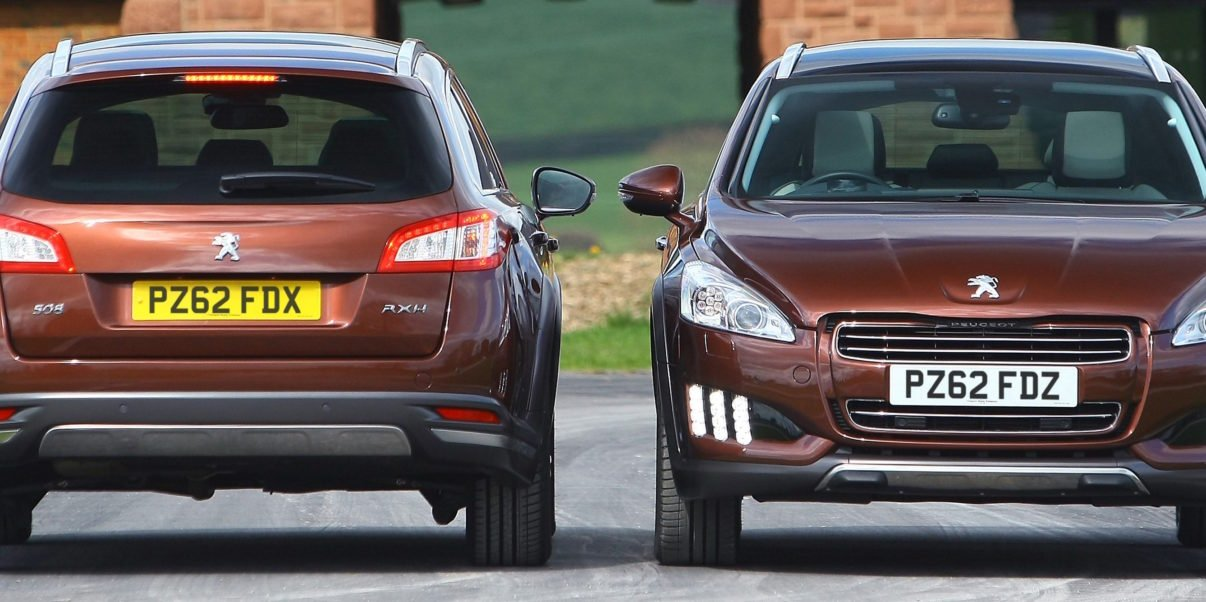

In [7]:
image_path = 'Car-Plates-test-image.jpg'

with open(image_path, 'rb') as f:
  np_image_string = np.array([f.read()])
  
image = Image.open(image_path)
width, height = image.size
np_image = np.array(image.getdata()).reshape(height, width, 3).astype(np.uint8)

display.display(display.Image(image_path, width=1024))

In [9]:
use_tpu = True #@param {type:"boolean"}
if use_tpu:
  import os
  import pprint

  assert 'COLAB_TPU_ADDR' in os.environ, 'ERROR: Not connected to a TPU runtime; please see the first cell in this notebook for instructions!'
  TPU_ADDRESS = 'grpc://' + os.environ['COLAB_TPU_ADDR']
  print('TPU address is', TPU_ADDRESS)

  session = tf.Session(TPU_ADDRESS, graph=tf.Graph())
  print('TPU devices:')
  pprint.pprint(session.list_devices())
else:
  session = tf.Session(graph=tf.Graph())

TPU address is grpc://10.100.25.138:8470
TPU devices:
[_DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:CPU:0, CPU, -1, 9864338561864180232),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 10285720203762277405),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 2467240093713865259),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 2774885293713927290),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 2694191910438320649),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:3, TPU, 17179869184, 8248458522716645804),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:4, TPU, 17179869184, 8371239070878169512),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:5, TPU, 17179869184, 1008134656849765738),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:6, TPU, 17179869184, 10824324317724

In [10]:
saved_model_dir = 'gs://cloud-tpu-checkpoints/mask-rcnn/1555659850' #@param {type:"string"}
_ = tf.saved_model.loader.load(session, ['serve'], saved_model_dir)

Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.loader.load or tf.compat.v1.saved_model.load. There will be a new function for importing SavedModels in Tensorflow 2.0.
INFO:tensorflow:Restoring parameters from gs://cloud-tpu-checkpoints/mask-rcnn/1555659850/variables/variables


In [11]:
num_detections, detection_boxes, detection_classes, detection_scores, detection_masks, image_info = session.run(
    ['NumDetections:0', 'DetectionBoxes:0', 'DetectionClasses:0', 'DetectionScores:0', 'DetectionMasks:0', 'ImageInfo:0'],
    feed_dict={'Placeholder:0': np_image_string})

num_detections = np.squeeze(num_detections.astype(np.int32), axis=(0,))
detection_boxes = np.squeeze(detection_boxes * image_info[0, 2], axis=(0,))[0:num_detections]
detection_scores = np.squeeze(detection_scores, axis=(0,))[0:num_detections]
detection_classes = np.squeeze(detection_classes.astype(np.int32), axis=(0,))[0:num_detections]
instance_masks = np.squeeze(detection_masks, axis=(0,))[0:num_detections]
ymin, xmin, ymax, xmax = np.split(detection_boxes, 4, axis=-1)
processed_boxes = np.concatenate([xmin, ymin, xmax - xmin, ymax - ymin], axis=-1)
segmentations = coco_metric.generate_segmentation_from_masks(instance_masks, processed_boxes, height, width)

In [12]:
#identifying which classes are present in the detection
detected_cars = []

for obj in range(len(detection_classes)):
  print(obj, ID_MAPPING[detection_classes[obj]])
  if ID_MAPPING[detection_classes[obj]] == 'car' and detection_scores[obj]>=0.5:
    detected_cars.append(segmentations[obj])

0 car
1 car
2 truck
3 car
4 truck


In [13]:
# detection probabilities of detected classes in the image
print(detection_scores)

[0.9874956  0.97112894 0.08879757 0.0591559  0.05563452]


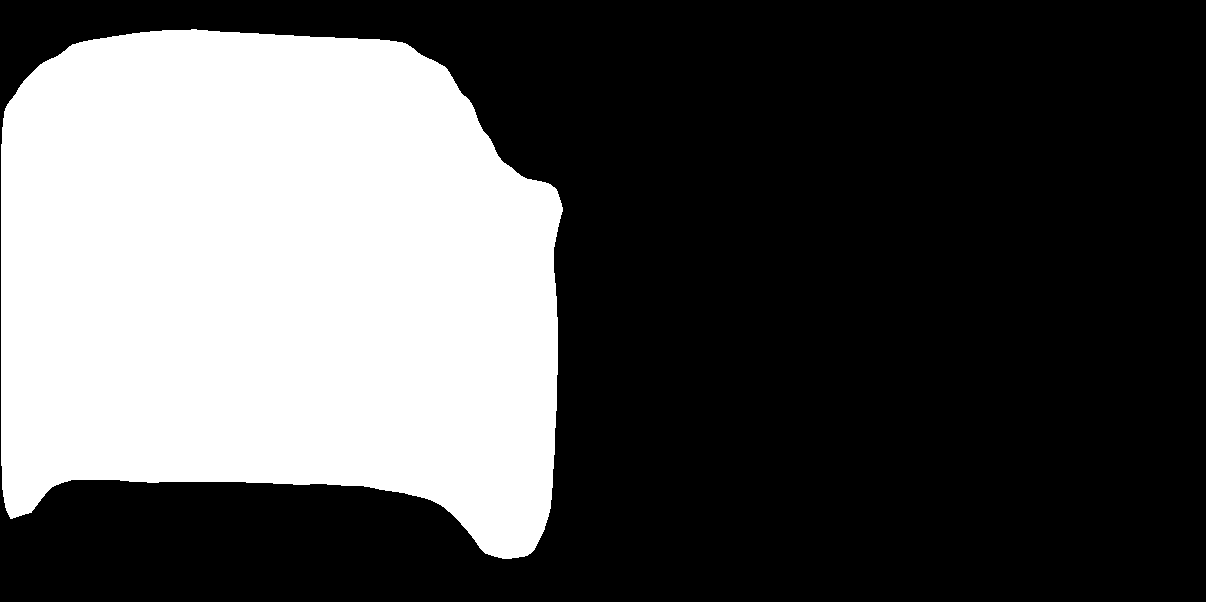

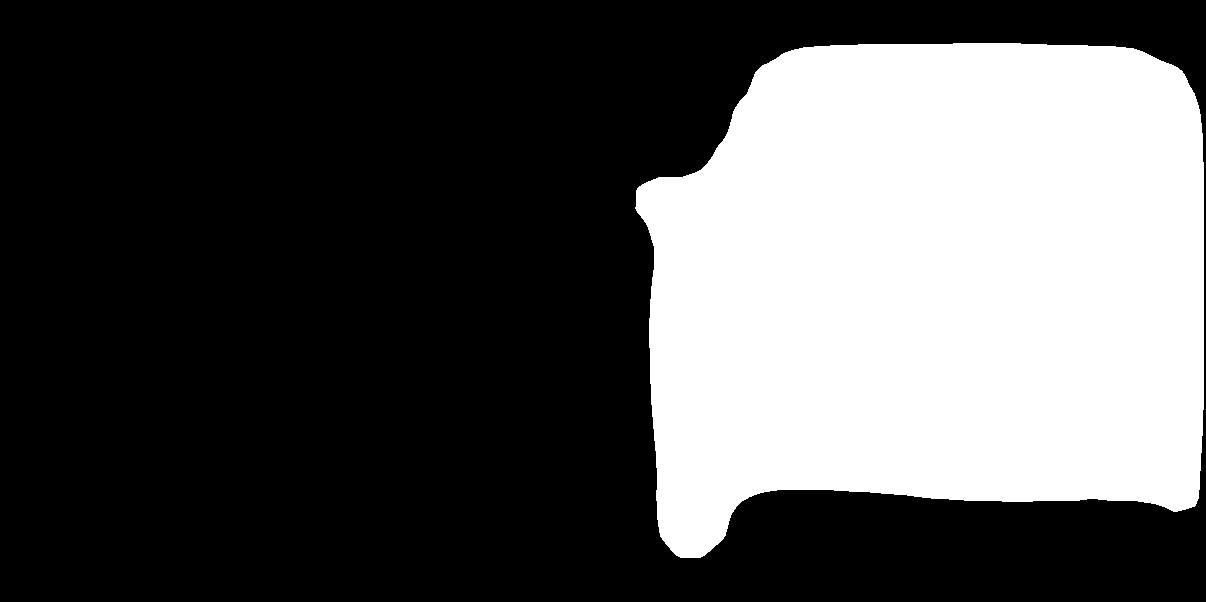

In [14]:
for car in detected_cars:

  cv2_imshow(255*car)

In [15]:
extracted_cars = []
input_img = cv2.imread('Car-Plates-test-image.jpg')

for mask in detected_cars:

  temp = input_img.copy()
  temp[mask == 0] = 0
  extracted_cars.append(temp)


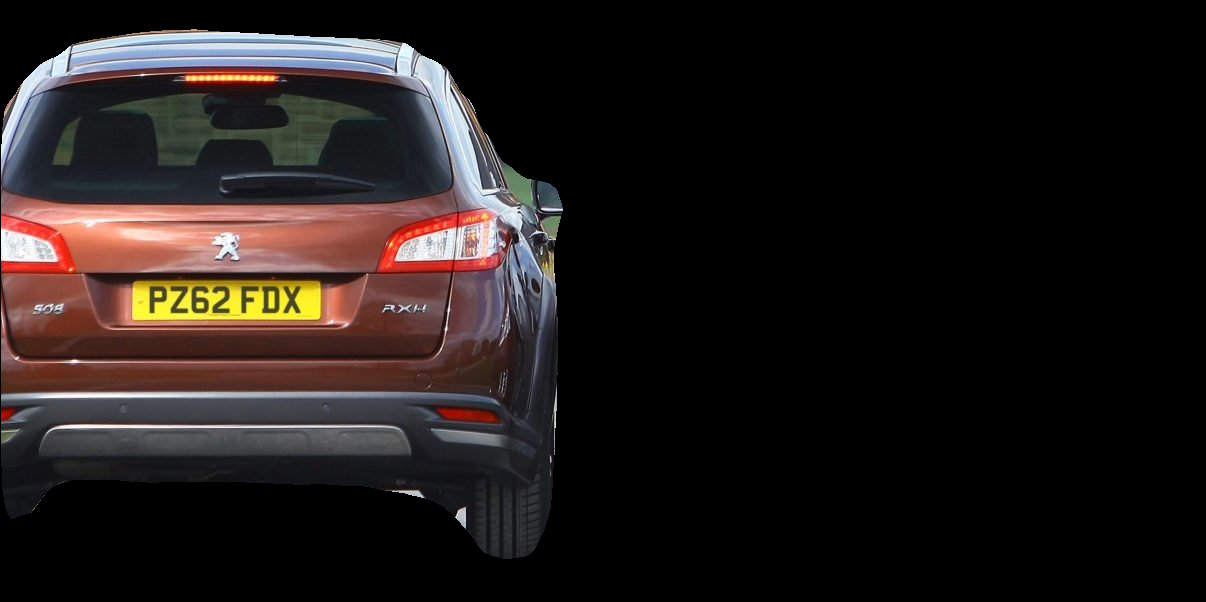

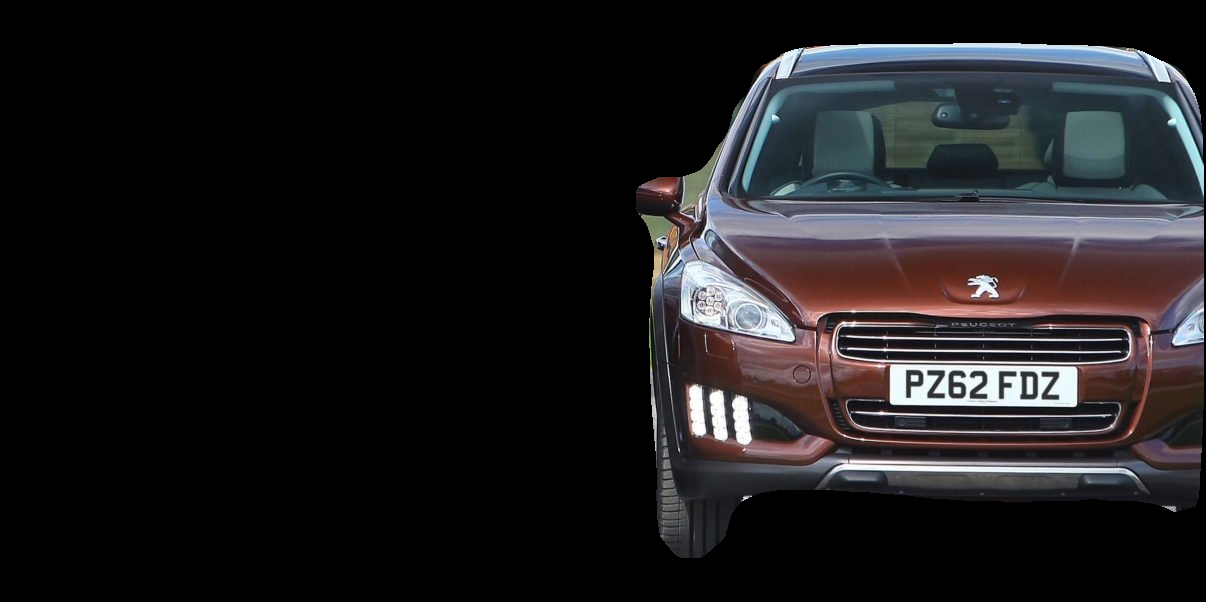

In [16]:
for car in extracted_cars:

  cv2_imshow(car)

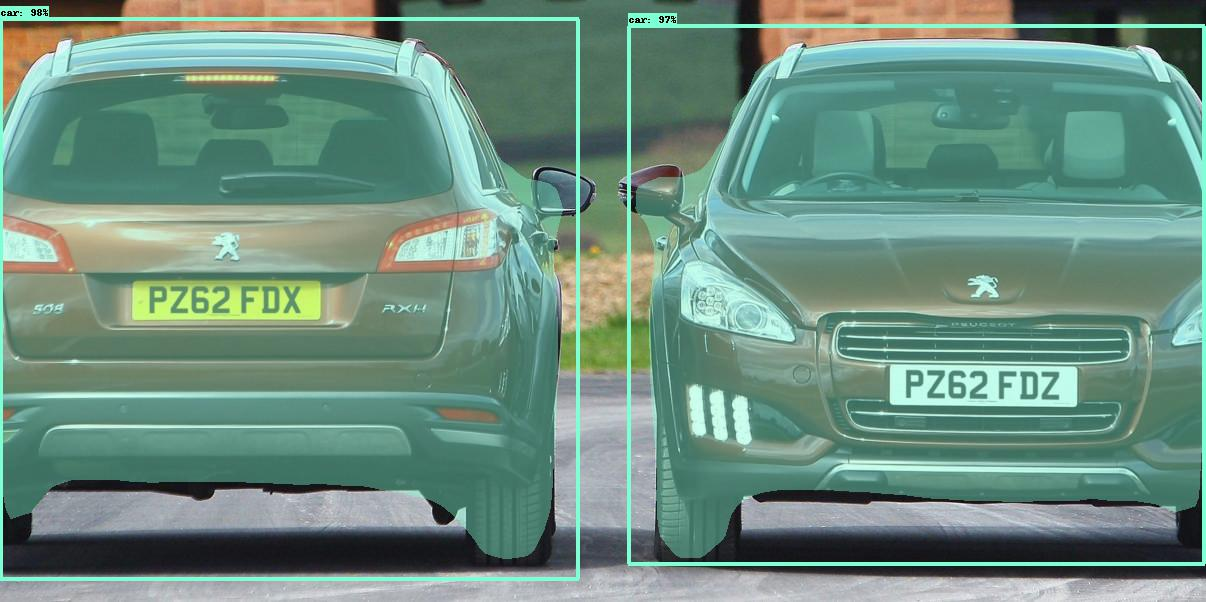

In [17]:
max_boxes_to_draw = 10   #@param {type:"integer"}
min_score_thresh = 0.2    #@param {type:"slider", min:0, max:1, step:0.01}

image_with_detections = visualization_utils.visualize_boxes_and_labels_on_image_array(
    np_image,
    detection_boxes,
    detection_classes,
    detection_scores,
    category_index,
    instance_masks=segmentations,
    use_normalized_coordinates=False,
    max_boxes_to_draw=max_boxes_to_draw,
    min_score_thresh=min_score_thresh)
output_image_path = 'test_results.jpg'
Image.fromarray(image_with_detections.astype(np.uint8)).save(output_image_path)
display.display(display.Image(output_image_path, width=1024))

# Vehicle number detection and recognition 

In [20]:
def recognize_text(img_path):
    '''loads an image and recognizes text.'''
    
    reader = easyocr.Reader(['en'])
    return reader.readtext(img_path)

In [21]:
result = []

for car in extracted_cars:
  result.append(recognize_text(car))

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


In [22]:
import datetime
now = datetime.datetime.now()

with open('output.txt', 'w') as f:
  for output in range(1,len(result)+1):
    for detected_obj in result[output-1]:
      if detected_obj[2]>0.5:
        f.write("Time stamp: "+str(now)+"\n"+"Registration number of car "+str(output)+" detected: "+str(detected_obj[1])+" with probability "+str(detected_obj[2]) )
        f.write('\n')


122

1

121

1

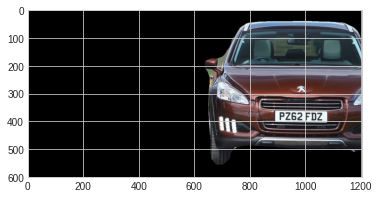

In [23]:
img_1 = extracted_cars[1]
img_1 = cv2.cvtColor(img_1, cv2.COLOR_BGR2RGB)
plt.imshow(img_1)

In [24]:
def overlay_ocr_text(img, save_name):
    '''loads an image, recognizes text, and overlays the text on the image.'''
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    dpi = 80
    fig_width, fig_height = int(img.shape[0]/dpi), int(img.shape[1]/dpi)
    plt.figure()
    f, axarr = plt.subplots(1,2, figsize=(fig_width, fig_height)) 
    axarr[0].imshow(img)
    
    # recognize text
    result = recognize_text(img)

    # if OCR prob is over 0.5, overlay bounding box and text
    for (bbox, text, prob) in result:
        if prob >= 0.5:
            # display 
            print(f'Detected text: {text} (Probability: {prob:.2f})')

            # get top-left and bottom-right bbox vertices
            (top_left, top_right, bottom_right, bottom_left) = bbox
            top_left = (int(top_left[0]), int(top_left[1]))
            bottom_right = (int(bottom_right[0]), int(bottom_right[1]))

            # create a rectangle for bbox display
            cv2.rectangle(img=img, pt1=top_left, pt2=bottom_right, color=(255, 0, 0), thickness=10)

            # put recognized text
            cv2.putText(img=img, text=text, org=(top_left[0], top_left[1] - 10), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, color=(255, 0, 0), thickness=8)
        
    # show and save image
    axarr[1].imshow(img)
    plt.savefig(f'./{save_name}_overlay.jpg', bbox_inches='tight')

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


Detected text: Pz62 FDX (Probability: 0.68)


CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


Detected text: PZ62 FDZ (Probability: 0.76)


<Figure size 432x288 with 0 Axes>

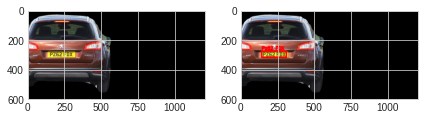

<Figure size 432x288 with 0 Axes>

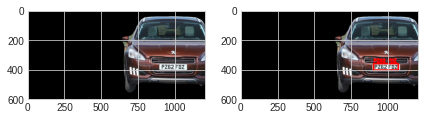

In [27]:
# overlaying detected text on the image

for car in range(len(extracted_cars)):
  overlay_ocr_text(extracted_cars[car], str(car)+'_carplate')